In [3]:
from sqlalchemy import create_engine
from config_loader import cf as config
from pprint import pprint

dbURL = config.get('MYSQL_DB', 'conn')
engine = create_engine(dbURL, encoding='utf-8', connect_args={'auth_plugin': 'mysql_native_password'})

In [5]:
sample = engine.execute("select * from tickers limit 10").fetchall()
# print(sample.fetchall())

findBest = lambda x: max(zip([t[8] for t in x], x))
stock = findBest(sample)

In [3]:
import pandas as pd
companies = pd.read_sql_query('select * from base_stocks', con = engine)

In [4]:
trade_dt = '20200720'
tkDF = pd.read_sql_query('select * from tickers where trade_date = "{}"'.format(trade_dt), con = engine, parse_dates=['trade_date'])

In [5]:
stocks, p_close, p_chg, vols = list(tkDF['ts_code']), list(tkDF['close']), list(tkDF['pct_chg']), list(tkDF['vol'])
s_id, s_name, s_area, s_ind, s_mkt = list(companies['ts_code']), list(companies['name']), list(companies['area']), list(companies['industry']), list(companies['market'])
names = dict(zip(s_id, s_name))
areas = dict(zip(s_id, s_area))
industries = dict(zip(s_id, s_ind))
markets = dict(zip(s_id, s_mkt))

In [6]:
# getTopVols = lambda tops: sorted({p[0]:'{}:{}'.format(p[0], p[1]) for p in zip(vols, stocks)}, reverse=True)[:tops]
# x = getTopVols(10)
# x
# max(zip(vols, stocks))
# companies[companies['ts_code']=='000725.SZ']
getTops = lambda idx, tops: (sorted(zip(stocks, idx), key=lambda x:(x[1]), reverse=True)[:tops])
pprint(companies[companies['ts_code']=='000725.SZ'])
pprint([(x, industries.get(x[0])) for x in getTops(p_chg, 10)])

ts_code  symbol  name area industry market list_date
266  000725.SZ  000725  京东方A   北京      元器件     主板  20010112
[(('688256.SH', 229.8649), '元器件'),
 (('688488.SH', 121.015), '生物制药'),
 (('300848.SZ', 44.0028), '化工原料'),
 (('688186.SH', 17.3657), '特种钢'),
 (('601600.SH', 10.1587), '铝'),
 (('600496.SH', 10.1235), '钢加工'),
 (('300080.SZ', 10.1075), '半导体'),
 (('600409.SH', 10.099), '化工原料'),
 (('688002.SH', 10.0976), '通信设备'),
 (('000488.SZ', 10.0952), '造纸')]


In [7]:
stockDF = pd.read_sql_query('select * from tickers where ts_code = "{}"'.format("000725.SZ"), con = engine, parse_dates=['trade_date'])
close_price = list(stockDF['close'])
trade_date = list(stockDF['trade_date'])
pp_array = [(pre, next) for pre,next in zip(close_price[:-1], close_price[1:])]

In [8]:
# change_array = map(lambda pp: reduce(lambda a, b: round((b-a)/a, 3), pp), pp_array)
change_array = list(map(lambda x: round((x[1]-x[0])*100/x[0], 2), pp_array))
change_array.insert(0, 0)

In [9]:
# change_array.insert(0, 0)
list(zip(map(lambda f: f.strftime('%Y%m%d'), trade_date), change_array))[:20]

[('20150105', 0),
 ('20150106', 0.87),
 ('20150107', -0.29),
 ('20150108', -2.01),
 ('20150109', -2.35),
 ('20150112', -3.3),
 ('20150113', 1.55),
 ('20150114', -2.45),
 ('20150115', 2.19),
 ('20150116', 0.92),
 ('20150119', -8.51),
 ('20150120', 2.99),
 ('20150121', 2.9),
 ('20150122', 0.0),
 ('20150123', -1.25),
 ('20150126', 1.27),
 ('20150127', 0.31),
 ('20150128', -1.25),
 ('20150129', -0.95),
 ('20150130', -0.64)]

In [11]:
from collections import namedtuple, OrderedDict

stock_tuple = namedtuple('stock', ('date', 'price', 'change'))
# [ (trd_dt, stock_tuple(trd_dt, price, change)) for trd_dt, price, change in zip(map(lambda t: t.strftime('%Y%m%d'), trade_date), close_price, change_array]
stock_dict = OrderedDict((trd_dt, stock_tuple(trd_dt, price, change)) for trd_dt, price, change in zip(map(lambda t: t.strftime('%Y%m%d'), trade_date), close_price, change_array))

In [36]:
# stock_dict
# a = list(stock_dict.values())[1].change
x = filter(lambda x: x.change > 0, stock_dict.values())
sum([x.change for x in x])

1306.36

In [43]:
from functools import partial

def filter_stock(stock_dict, up_or_down, sum_flag):
    if not isinstance(stock_dict, OrderedDict):
        raise TypeError('stock_dict must be OrderedDict')
    wanted_stocks = filter(lambda x: x.change > 0 if up_or_down else x.change <= 0, stock_dict.values())
    if not sum_flag:
        return OrderedDict({x.date:x for x in wanted_stocks})
    else:
        return sum([x.change for x in wanted_stocks])

filter_up_sum = partial(filter_stock, up_or_down=True, sum_flag=True)
filter_down_sum = partial(filter_stock, up_or_down=False, sum_flag=True)

In [46]:
# filter_stock(stock_dict, up_or_down=True, sum_flag=False)
# filter_up_sum(stock_dict)
# filter_down_sum(stock_dict)
# locals()
len(filter_stock(stock_dict, up_or_down=True, sum_flag=False))
len(filter_stock(stock_dict, up_or_down=False, sum_flag=False))

745

In [3]:
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt

from trade_loopback import TradeLoopBack
from trade_days import TradeDays
from trade_strategies.base_strategy import GamblerStrategy
from trade_strategies.mean_strategy import MeanStrategy

In [6]:
trade_days = TradeDays(code='000001.SZ', base_date='20190101')
loopback = TradeLoopBack(trade_days, MeanStrategy())
loopback.execute_trade()
print('{:.2f}%'.format(reduce(lambda a, b: a + b, loopback.profit_days)))

buy on 2019-05-06, at 12.87
sell on 2019-05-31, with profits chg -5.11
buy on 2020-02-03, at 13.99
sell on 2020-02-14, with profits chg 7.33
buy on 2020-03-19, at 12.23
sell on 2020-03-27, with profits chg 7.43
9.65%


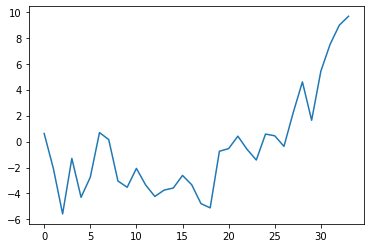

In [7]:
plt.plot(np.array(loopback.profit_days).cumsum())

In [1]:
import numpy as np

In [2]:
days_span = 100
stocks_pack = 8
trade_days = np.random.standard_normal((stocks_pack, days_span))

In [6]:
trade_days[:3, :20]

array([[-0.98646714,  0.5717363 ,  0.4841273 , -0.30672244,  1.98988984,
        -0.45668962,  0.07808311,  1.35701968, -0.66577324, -0.09153038,
         0.51309021,  1.06857437, -1.4126578 , -0.35281479, -0.87988688,
        -1.08673986, -1.08744667, -0.28389939, -0.56830804,  1.08641332],
       [-1.75663091, -0.45472888, -1.65534025, -0.6787362 , -0.56920741,
         0.76062406,  1.88780048,  0.80883472, -0.14363136, -0.76707735,
        -0.42982566, -1.22083179, -0.26392882,  0.86370009, -0.85969908,
         0.16169727, -1.09450795,  1.78689363, -0.10470494, -2.11899727],
       [ 0.90970708, -0.64776426, -1.26348211, -1.45745594, -0.23151057,
        -0.16989739,  0.11279812,  0.2868892 , -0.78291817, -0.33530385,
        -0.45881691,  0.27534799, -0.24716759,  2.04299097,  0.88663539,
         0.31810239, -0.17740117, -1.55956607, -0.84136483, -1.74047579]])

In [4]:
from datetime import datetime, date
from collections import namedtuple, OrderedDict
p = namedtuple('daypay', 'day veg meat fruit')
xdate = [datetime.strptime(str(x), '%Y%m%d') for x in [20200711 + d for d in range(15)]]
veg_list = [37, 0, 43.5, 46.44, 17.26, 11.65, 12, 16.7, 15.5, 53.95, 13, 14.8, 27.5, 68, 40]
meat_list = [334, 79, 23.8, 259.6, 14.9, 10, 50, 49.9, 154, 119.5, 0, 140.3, 148.8, 151, 419]
fruit_list = [25,49.11, 9.9, 61.8,4.5,13,8,35,63,49.9,53,29.9,0,0,37]

# self.__stocks = OrderedDict((x[0], stock_tuple(x[0], x[1], x[2], x[3])) for x in zip(stock_hist['trade_date'], stock_hist['close'], stock_hist['pct_chg'], stock_hist['vol']))
chart_dat = OrderedDict((x[0], p(x[0], x[1], x[2], x[3])) for x in zip(xdate, veg_list, meat_list, fruit_list))

Text(0.5, 1.0, '15 days')

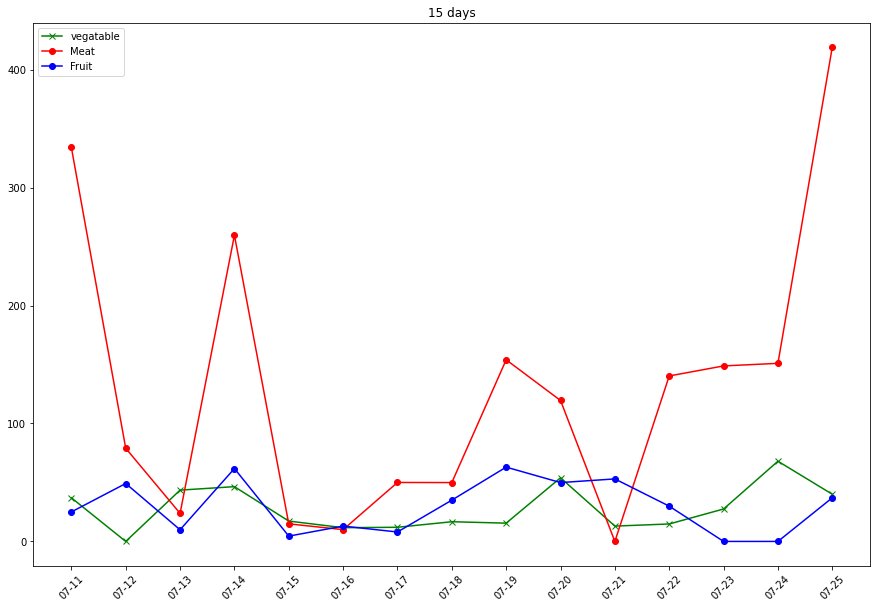

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdate

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)
ax.xaxis.set_major_formatter(mdate.DateFormatter('%m-%d'))
ax.xaxis.set_major_locator(mdate.DayLocator())
ax.plot(xdate, veg_list, '-gx', label='vegatable')   
ax.plot(xdate, meat_list, '-ro', label='Meat')  
ax.plot(xdate, fruit_list, '-bo', label='Fruit')  
ax.legend(loc='top', shadow=False)
plt.xticks(rotation=45)
plt.title('15 days')

In [66]:
print('{:.2f}'.format(sum(fruit_list)))
#  + \
# sum(meat_list) + \
# print(veg_list)
# sum(veg_list)

439.11


Text(0.5, 1.0, 'Veg:417.30 Meat:1953.80, Fruit:439.11 - Total:2810.21')

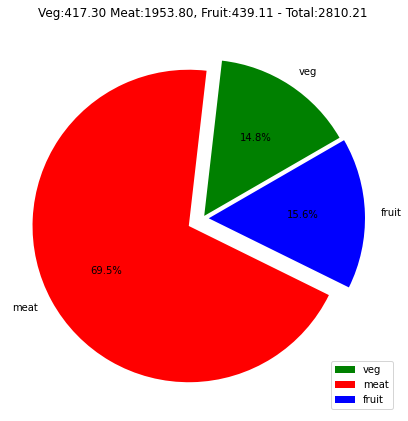

In [8]:
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdate

total_types = [sum(x) for x in [veg_list, meat_list, fruit_list]]

fig = plt.figure(figsize=(7, 8))
ax = fig.add_subplot(1,1,1)
ax.pie(total_types, labels=['veg', 'meat', 'fruit'], colors = ['green', 'red', 'blue'], startangle=30, autopct='%1.1f%%', explode=(0.02, 0.1, 0.04))
ax.legend(loc='top', shadow=False)
plt.title('Veg:{:.2f} Meat:{:.2f}, Fruit:{:.2f} - Total:{}'.format(*total_types, sum(total_types)))

In [6]:
import numpy as np
s_arr = np.random.standard_normal((50, 200))
s_20 = s_arr[:20,:100].copy()
e_20 = s_arr[-20:, :100].copy()
s_5 = s_20[:5, :10].copy()

In [42]:
# a = s_20[s_20 > 0.2]
# np.all(a>0.2)
# np.any(s_20[s_20 > 0.2]<0.25)
# np.minimum(s_20, e_20)
# np.diff(s_20, axis=0)
np.where(s_20>0.8, 1, -1)


array([[-1, -1,  1, ..., -1, -1, -1],
       [-1,  1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ...,  1, -1,  1],
       ...,
       [ 1, -1, -1, ..., -1, -1, -1],
       [-1,  1, -1, ..., -1, -1, -1],
       [-1, -1,  1, ..., -1, -1, -1]])

In [15]:
np.max(s_5,axis=1)

array([0.5610529 , 2.00492073, 1.44126721, 1.65088544, 1.25121461])

In [29]:
from pprint import pprint
pprint('min={}'.format(np.min(s_5, axis=1)))
pprint('std={}'.format(np.std(s_5, axis=1)))
pprint('max={}'.format(np.max(s_5, axis=1)))
np.var(s_5, axis=0)

'min=[-1.83818479 -1.75489692 -2.88538071 -1.11646901 -1.70065743]'
'std=[0.740349   1.16082195 1.28748823 0.87871747 0.9464678 ]'
'max=[0.5610529  2.00492073 1.44126721 1.65088544 1.25121461]'


array([0.47745564, 1.61324083, 0.06173888, 2.67859001, 1.0636378 ,
       0.19405392, 0.74047954, 0.90094457, 0.82731539, 1.58662885])

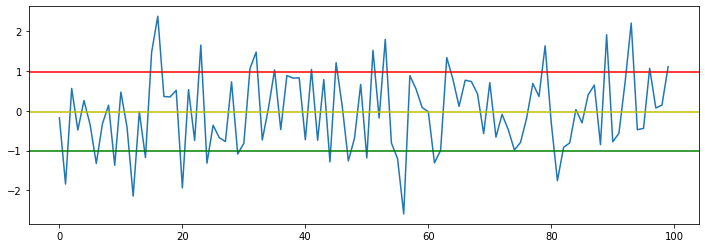

In [43]:
import matplotlib.pyplot as plt
s_mean = np.mean(s_20[0])
s_std = np.std(s_20[0])
plt.figure(figsize=(12,4))
plt.plot(s_20[0])
plt.axhline(s_mean + s_std, color='r')
plt.axhline(s_mean, color='y')
plt.axhline(s_mean - s_std, color='g')

std:1.02 mean:0.10 min:-2.77 max:2.43
array([-2.76853963, -2.66249059, -2.55644155, -2.45039251, -2.34434347,
       -2.23829443, -2.13224539, -2.02619635, -1.92014731, -1.81409827,
       -1.70804923, -1.60200018, -1.49595114, -1.3899021 , -1.28385306,
       -1.17780402, -1.07175498, -0.96570594, -0.8596569 , -0.75360786,
       -0.64755882, -0.54150978, -0.43546074, -0.3294117 , -0.22336266,
       -0.11731362, -0.01126458,  0.09478446,  0.2008335 ,  0.30688254,
        0.41293158,  0.51898062,  0.62502966,  0.7310787 ,  0.83712774,
        0.94317678,  1.04922582,  1.15527486,  1.2613239 ,  1.36737294,
        1.47342199,  1.57947103,  1.68552007,  1.79156911,  1.89761815,
        2.00366719,  2.10971623,  2.21576527,  2.32181431,  2.42786335])


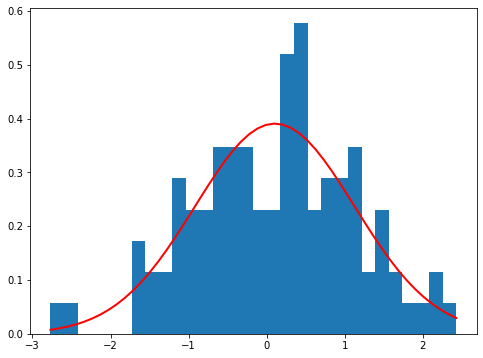

In [18]:
import matplotlib.pyplot as plt
from pprint import pprint

import scipy.stats as scs
s_data = s_20[2]
s_std = s_data.std()
s_mean = s_data.mean()
s_min = s_data.min()
s_max = s_data.max()
print('std:{:.2f} mean:{:.2f} min:{:.2f} max:{:.2f}'.format(s_std, s_mean, s_min, s_max))
plt.figure(figsize=(8,6))
plt.hist(s_data, bins=30, density = True)

f_line = np.linspace(s_min, s_max)
pprint(f_line)
# pdf = scs.norm(s_mean, s_std).pdf(f_line)
pdf = scs.norm(s_mean, s_std).pdf(f_line)
plt.plot(f_line, pdf, lw=2, c='r')

In [9]:
from local_utilities import load_as_df

In [13]:
all_tickers = load_as_df('select ts_code, trade_date, pct_chg from tickers where trade_date >= "2019-01-01"')

In [28]:
all_tk_ids = all_tickers['ts_code'].unique()
# all_tickers[['trade_date' == all_trade_days[0]]]
all_tk = []
for tk_id in all_tk_ids:
    all_tickers[all_tickers['ts_code'] == all_tk_ids[0]]['pct_chg']

0     -2.0256
1      0.9793
2      5.0647
3     -0.1026
4     -0.8214
        ...  
373   -0.0707
374    4.1726
375   -1.6293
376   -0.5521
377   -2.7759
Name: pct_chg, Length: 378, dtype: float64

In [53]:
import numpy as np
total_days = 504
keep_days = 50
s_200 = np.random.standard_normal((20,total_days))
s_test = s_200[:,:total_days-keep_days].copy()
s_pred = s_200[:,total_days-keep_days:].copy()
stock_lowers = np.argsort(np.sum(s_test, axis=1))[:3]

In [44]:
# sorted(np.sum(s_test, axis=1))[:3]
# s_test[stock_lowers].cumsum()
stock_lowers

array([50, 24, 64], dtype=int64)

In [54]:
for x in range(20):
    print(s_200[x].cumsum()[-1])

-21.81439847655737
6.358957390161041
-17.986288800056087
16.10856470936378
4.722050975102343
-3.1414841670365683
-25.852693031779907
3.008615759287503
67.92649760615915
-9.769755543501608
29.57104347274164
6.381942694063704
16.02167890383387
10.254830389160581
0.7029624747016988
-11.264346489358337
26.69958745118938
-22.40976984070991
0.34876578421834614
15.511828916047332


-0.6474919440408203

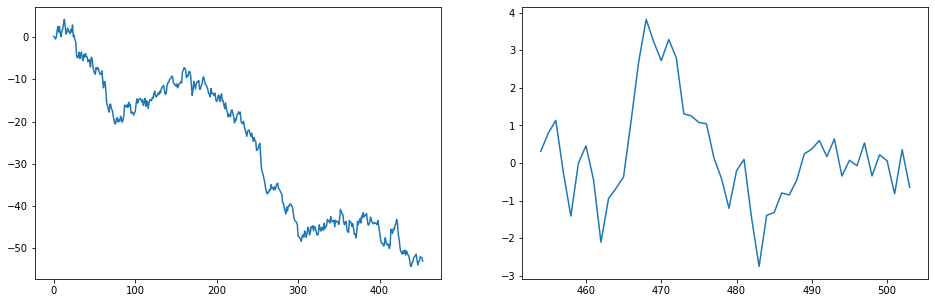

In [49]:
import matplotlib.pyplot as plt
low_stock = 50
_, splot = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
splot[0].plot(np.arange(0, total_days-keep_days), s_test[low_stock].cumsum())
splot[1].plot(np.arange(total_days-keep_days, total_days), s_200[low_stock][total_days-keep_days:total_days].cumsum())
s_200[low_stock][total_days-keep_days:total_days].cumsum()[-1]

In [2]:
import numpy as np
import pandas as pd

In [46]:
norm_arr = np.random.standard_normal((4,50))
pd.DataFrame(norm_arr)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.318811,-0.651772,0.531478,-2.255870,-1.174645,0.846345,-0.940942,0.981025,-0.209495,0.976774,...,1.032968,-0.412717,-2.816575,1.229429,-1.828645,-0.390706,0.032923,1.792419,0.719343,-1.249101
1,0.725735,-2.228252,1.216313,0.247336,-0.117484,1.725716,0.622348,1.688615,-0.058814,-0.564055,...,-3.292955,0.103257,-1.239902,0.969299,0.111123,1.500155,0.427134,1.918349,-0.477460,0.769483
2,-0.542463,0.959722,-0.163593,-1.198477,-0.550545,0.171284,1.048160,0.464018,-0.809604,0.575054,...,0.169311,-2.157096,1.475395,-2.826742,-0.013620,1.189151,0.859947,-0.948497,0.879433,0.245317
3,1.465195,-0.181783,1.617389,-1.588337,1.200527,0.518444,-2.381950,0.973111,0.472213,-1.207788,...,-0.575584,1.150355,-0.029672,0.818400,0.696481,0.083948,-0.019369,-0.105226,-0.333018,1.526675


In [66]:
stock_symbols = ['stock-{}'.format(x) for x in range(norm_arr.shape[0])]
date_symbols = pd.date_range(start='20200120',periods=norm_arr.shape[1],freq='1d')
df = pd.DataFrame(norm_arr, index=stock_symbols, columns=date_symbols)
# df1 = df.T.resample('3d').ohlc()
stock_0 = df.T['stock-0']

In [69]:
stock_0.head(10)

2020-01-20    0.318811
2020-01-21   -0.651772
2020-01-22    0.531478
2020-01-23   -2.255870
2020-01-24   -1.174645
2020-01-25    0.846345
2020-01-26   -0.940942
2020-01-27    0.981025
2020-01-28   -0.209495
2020-01-29    0.976774
Freq: D, Name: stock-0, dtype: float64

In [76]:
stock_0.resample('3d').ohlc().columns

Index(['open', 'high', 'low', 'close'], dtype='object')

In [79]:
from local_utilities import load_as_df

df = load_as_df('select trade_date,close,vol from tickers where ts_code = "000002.SZ"')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000019877013A60>,
      dtype=object)

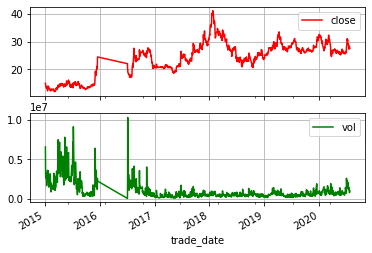

In [95]:
# list(df['trade_date'])[:10]
df.set_index(df['trade_date'])[['close','vol']].plot(subplots=True, style=['r', 'g'], grid=True)

In [44]:
grp = df[['ts_code','trade_date','pct_chg']].groupby('ts_code')
cnt = 0
for g_name, g_data in grp:
    # print(pd.DataFrame(g_data))
    g_data.reset_index()
    print('tt-{}'.format(pd.DataFrame(g_data, index=list(g_data['trade_date']))))
    break


tt-           ts_code trade_date  pct_chg
2020-01-02     NaN        NaN      NaN
2020-01-03     NaN        NaN      NaN
2020-01-06     NaN        NaN      NaN
